In [1]:
#GENERAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

#PATH PROCESS
import os
from pathlib import Path
import glob
from scipy.io import loadmat

# image processing
import cv2
from scipy.ndimage import gaussian_filter

# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision

# Exploring Dataset

Take one example to explore the structure of dataset

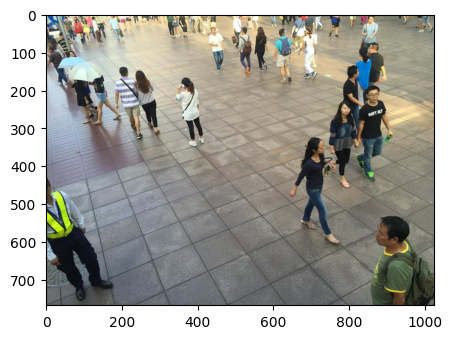

In [2]:
path_img_ex = '../input/shanghaitech/ShanghaiTech/part_B/train_data/images/IMG_6.jpg'
image_ex = cv2.cvtColor(cv2.imread(path_img_ex),cv2.COLOR_BGR2RGB)
figure = plt.figure(figsize=(5,5))
plt.imshow(image_ex)
plt.show()

In [3]:
path_gt_ex = "../input/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_6.mat"
gt_ex = loadmat(path_gt_ex)
print('type: ', type(gt_ex))
print(gt_ex.items())

type:  <class 'dict'>
dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 18 19:55:34 2016'), ('__version__', '1.0'), ('__globals__', []), ('image_info', array([[array([[(array([[  3.94945534, 469.96427015],
                       [919.86056645, 584.69019608],
                       [722.64575163, 353.34204793],
                       [794.70501089, 254.73464052],
                       [866.76427015, 219.65315904],
                       [815.56427015, 156.12723312],
                       [371.83093682, 180.77908497],
                       [251.416122  , 168.45315904],
                       [204.95686275, 154.23093682],
                       [ 12.48278867,  92.36427015],
                       [ 20.54204793,  71.50501089],
                       [ 70.31982571, 107.53464052],
                       [ 43.53464052,  59.06056645],
                       [ 84.18649237,  18.26056645],
                       [100.83834423,  16.18649237],
             

In [4]:
print(gt_ex.keys())

dict_keys(['__header__', '__version__', '__globals__', 'image_info'])


In [5]:
gt_coor_ex = gt_ex.get('image_info')[0][0][0][0][0]
print('Shape of coordinates: ', gt_coor_ex.shape)
#print(gt_coor_ex)


Shape of coordinates:  (36, 2)


The keyword 'image_info' gives the coordinates of location of each person in the image.

The shape[0] indicates the amount of people in the image.

Text(0.5, 1.0, 'Image and Coordinate')

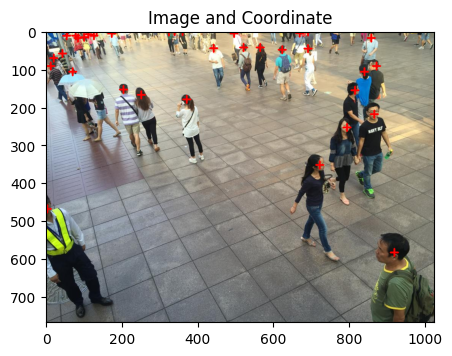

In [6]:
figure = plt.figure(figsize=(5,5))

for x_cor, y_cor in gt_coor_ex:
    cv2.drawMarker(image_ex, (int(x_cor), int(y_cor)),(255, 0, 0),thickness=3)

plt.imshow(image_ex)
plt.title("Image and Coordinate")

Extract the coordinate as density map. With the function *create_density_map*, the coordinate of people can be visulized, the sum of the density map is the amount of people in the image, the size of the density map is the same as the image.

The density map will be used as 'label' for neural network.

In [7]:
def gen_density_map_gaussian(image, coords, sigma=5):
    img_zeros = np.zeros((image.shape[:2]), dtype=np.float32)
    for x_cor, y_cor in coords:
        img_zeros[int(y_cor), int(x_cor)] = 1

    density_map = gaussian_filter(img_zeros,sigma=sigma,truncate=5*5)

    return density_map

max1 :  tensor(1.)
max2 :  0.012646893
min1 :  tensor(0.)
min2 :  0.0


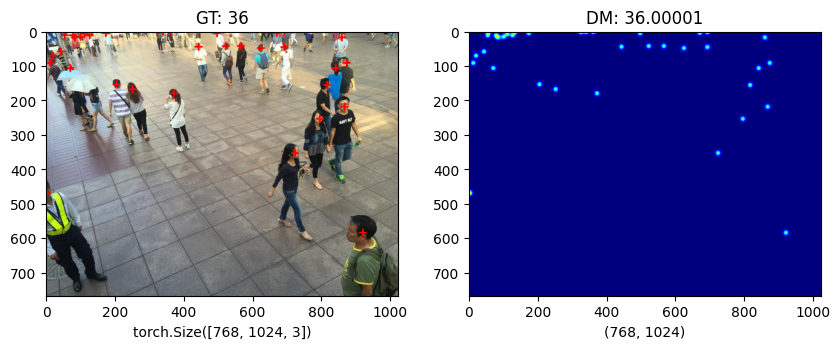

In [8]:
density_map_ex = gen_density_map_gaussian(image_ex, gt_coor_ex, 5)

figure = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
image_ex = torch.tensor(image_ex/255, dtype=torch.float)
plt.xlabel(image_ex.shape)
plt.title('GT: '+str(gt_coor_ex.shape[0]))
plt.imshow(image_ex)

plt.subplot(1,2,2)
plt.xlabel(density_map_ex.shape)
plt.title('DM: '+str(np.sum(density_map_ex)))
plt.imshow(density_map_ex, cmap="jet")

print('max1 : ', image_ex.max())
print('max2 : ', density_map_ex.max())
print('min1 : ', image_ex.min())
print('min2 : ', density_map_ex.min())

# Load Data

Create a data loader extract the key 'image_info' in MAT to obtain the coordinates of people location. Then use the *gen_density_map_gaussian* to create the density map of each image. In addition, take the dimension of the coordinate matrix as number of people, which can be used for model loss function. Downsample is applied in order to fit the shape of density map at output of training model.

In [9]:
import torch
import torchvision.transforms as T
import numpy as np
import cv2
import os
import random
from torch.utils.data import Dataset
from scipy.io import loadmat

class EnhancedShanghaiTechDataset(Dataset):
    def __init__(self, root_dir, gt_downsample=4, shuffle=False, sigma_base=5, augment=False):
        self.root_dir = root_dir
        self.gt_downsample = gt_downsample
        self.shuffle = shuffle
        self.sigma_base = sigma_base
        self.augment = augment

        # Load image file names
        self.img_names = [filename for filename in os.listdir(os.path.join(root_dir, 'images')) if filename.endswith('.jpg')]
        if self.shuffle:
            random.shuffle(self.img_names)

        # Initialize dictionaries to hold density maps and person counts
        self.n_people = {}
        self.DMs = {}
        
        # Pre-compute density maps
        for image_filename in self.img_names:
            img_path = os.path.join(root_dir, 'images', image_filename)
            GT_filename = 'GT_' + image_filename.split('.')[0] + '.mat'
            path_GT = os.path.join(root_dir, 'ground-truth', GT_filename)
            GT = loadmat(path_GT).get('image_info')[0][0][0][0][0]
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            self.DMs[img_path] = self.generate_density_map(img, GT)
            self.n_people[img_path] = GT.shape[0]

        # Define augmentation transforms
        self.augmentation = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomRotation(degrees=10),
            T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        ])

    def generate_density_map(self, img, points):
        density_map = np.zeros(img.shape[:2], dtype=np.float32)
        num_points = len(points)
        for point in points:
            y, x = int(point[1]), int(point[0])
            sigma = self.sigma_base * (0.5 if num_points > 100 else 1)
            gauss_radius = int(3 * sigma)
            
            # Define boundaries while ensuring they fit within the image dimensions
            x_min, x_max = max(0, x - gauss_radius), min(img.shape[1], x + gauss_radius + 1)
            y_min, y_max = max(0, y - gauss_radius), min(img.shape[0], y + gauss_radius + 1)
            
            # Adjust kernel size to match the region of the density map
            kernel_x = cv2.getGaussianKernel(x_max - x_min, sigma)
            kernel_y = cv2.getGaussianKernel(y_max - y_min, sigma)
            kernel = kernel_y * kernel_x.T
            
            density_map[y_min:y_max, x_min:x_max] += kernel
        
        # Normalize the density map
        return density_map / (np.sum(density_map) / num_points) if num_points > 0 else density_map


    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, 'images', self.img_names[index])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        gt_density_map = self.DMs[img_path]
        gt_n_people = self.n_people[img_path]

        # Apply data augmentation if enabled
        if self.augment:
            img = T.ToPILImage()(img)
            img = self.augmentation(img)
            img = np.array(img)

        # Downsample
        ds_rows = int(img.shape[0] // self.gt_downsample)
        ds_cols = int(img.shape[1] // self.gt_downsample)
        img = cv2.resize(img, (ds_cols * self.gt_downsample, ds_rows * self.gt_downsample))
        gt_density_map = cv2.resize(gt_density_map, (ds_cols, ds_rows))
        gt_density_map = gt_density_map[np.newaxis, :, :] * self.gt_downsample * self.gt_downsample

        # Convert image to tensor
        img = img.transpose((2, 0, 1))
        img_tensor = torch.tensor(img / 255, dtype=torch.float)
        dm_tensor = torch.tensor(gt_density_map, dtype=torch.float)

        return img_tensor, dm_tensor, gt_n_people


In [10]:
root_dir = "../input/shanghaitech/ShanghaiTech/part_B/test_data/"
dataset = EnhancedShanghaiTechDataset(root_dir, gt_downsample=4, shuffle=True, sigma_base=5)


Print some samples of dataset as a sanity check

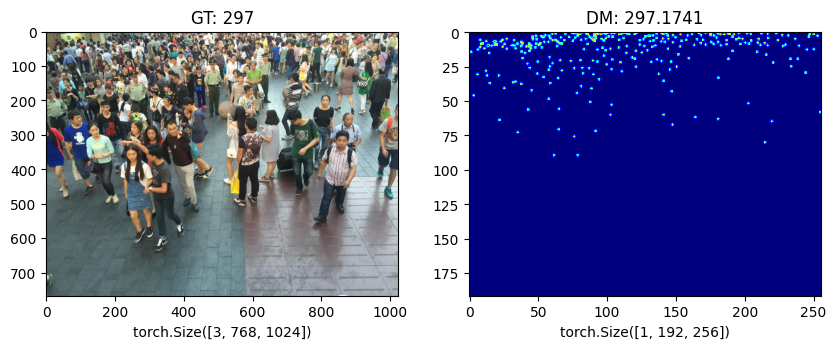

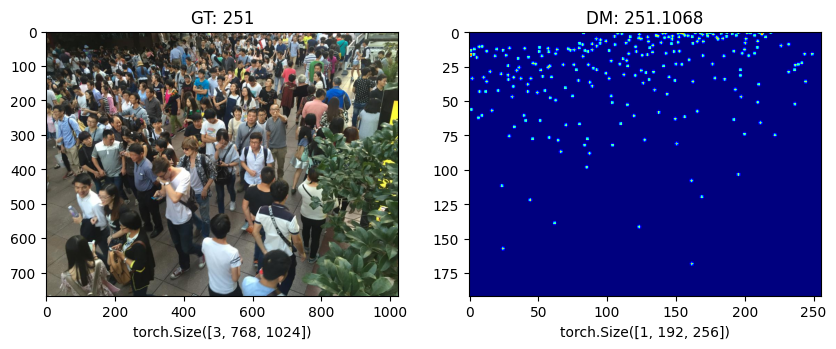

In [11]:
for i, (img, gt_dmap, n_people) in enumerate(dataset):
  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  plt.xlabel(img.shape)
  plt.title('GT: ' + str(n_people))
  plt.imshow(img.permute(1, 2, 0))

  plt.subplot(1,2,2)
  plt.xlabel(gt_dmap.shape)
  plt.title('DM: ' + str(np.sum(gt_dmap.numpy())))
  plt.imshow(gt_dmap.permute(1, 2, 0), cmap="jet")
  plt.show()

  if i > 0:
    #print('type of img: ', type(img))
    #print('type of dmap: ', type(gt_dmap))
    #print('shape of img: ', img.shape)
    break


# Create Model for Neural Network

Build a multi-column convolutional neural network for density map prediction.

The multi-column CNN consists of multiple parallel CNN columns, each processing the input data independently and at different resolutions. In the proposed architecture, the 1st column is with lowest resolution (with largest kernel size), and lowest depth; 2nd column has incresing resolution (smaller kernel size), and larger depth, and so on.

Each CNN column learns to extract features that contains different aspects from the input data. After feature extraction, the outputs from the all CNN columns are combined by concatenation. The combined features are passed through a single convolutional layer to generate the final output.

In [12]:
class MC_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.column1 = nn.Sequential(
            nn.Conv2d(3, 8, 9, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 7, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 7, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 16, 7, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 8, 7, padding='same'),
            nn.ReLU(),
        )

        self.column2 = nn.Sequential(
            nn.Conv2d(3, 10, 7,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, 5,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 40, 5,padding='same'),
            nn.ReLU(),
            nn.Conv2d(40, 20, 5,padding='same'),
            nn.ReLU(),
            nn.Conv2d(20, 10, 5,padding='same'),
            nn.ReLU(),
        )

        self.column3 = nn.Sequential(
            nn.Conv2d(3, 12, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(12, 24, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 48, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(48, 24, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(24, 12, 3, padding='same'),
            nn.ReLU(),
        )
        

        self.fusion_layer = nn.Sequential(
            nn.Conv2d(30, 1, 1, padding=0),
            #nn.ReLU()
        )


    def forward(self,img_tensor):
        x1 = self.column1(img_tensor)
        x2 = self.column2(img_tensor)
        x3 = self.column3(img_tensor)
        x = torch.cat((x1, x2, x3),1)
        x = self.fusion_layer(x)
        return x


In [13]:
img=torch.rand((1,3,768,1024),dtype=torch.float)
mcnn=MC_CNN()
out_dmap=mcnn(img)
print(out_dmap.shape)

torch.Size([1, 1, 192, 256])


# Prepare the data for traning, validation, and testing

In [14]:
batch_size = 8
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_root_dir = "../input/shanghaitech/ShanghaiTech/part_B/train_data/"
init_training_set = EnhancedShanghaiTechDataset(train_root_dir, gt_downsample=4, shuffle=True)

# split part of the training set as validation set
train_size = int(0.9 * len(init_training_set))
val_size = len(init_training_set) - train_size

train_indices = list(range(train_size))
val_indices = list(range(train_size, len(init_training_set)))
train_dataset = torch.utils.data.dataset.Subset(init_training_set, train_indices)
val_dataset = torch.utils.data.dataset.Subset(init_training_set, val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_root_dir = "../input/shanghaitech/ShanghaiTech/part_B/test_data/"
test_set = EnhancedShanghaiTechDataset(test_root_dir, gt_downsample=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in val_loader:", len(val_loader))
print("Number of batches in test_loader:", len(test_loader))

Number of batches in train_loader: 45
Number of batches in val_loader: 5
Number of batches in test_loader: 40


In [15]:
def plot_corresponding_pairs(batch1, batch2, plot_map='jet'):
    num_images = batch1.shape[0] # can change to 4 if for entire data set

    fig, axes = plt.subplots(int(np.ceil(num_images/2)), 4)

    for i in range(num_images):
        axes[int(i/4)*2, i%4].imshow(batch1[i].permute(1, 2, 0))
        axes[int(i/4)*2, i%4].axis('off')

        axes[int(i/4)*2+1, i%4].imshow(batch2[i].squeeze().detach().numpy(), cmap=plot_map)
        axes[int(i/4)*2+1, i%4].axis('off')
        axes[int(i/4)*2+1, i%4].set_title('DM: ' + str(np.sum(batch2[i].detach().numpy())))

    plt.tight_layout()
    plt.show()

Print some samples of dataset as a sanity check

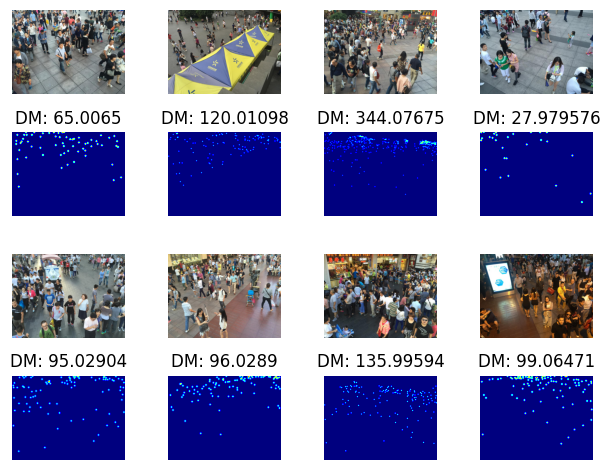

   65   120   344    28    95    96   136    99


In [16]:
dataiter = iter(train_loader)
ex_images, ex_dmaps, ex_n_people = next(dataiter)


# Show images and density map
plot_corresponding_pairs(ex_images, ex_dmaps)

# Print Ground truth number of people
print(' '.join('%5s' % ex_n_people[j].item() for j in range(batch_size)))

# Training Phase

Define a cost function that considering 
* Difference between density map and predicted image
* Difference between sum of predicted image (refering number of people) and the ground truth number of people

In [17]:
class CombinedLoss(nn.Module):
    def __init__(self, weight_dmap=0.8, weight_sum_gt=0.2):
        super().__init__()
        self.weight_dmap = weight_dmap
        self.weight_sum_gt = weight_sum_gt
        self.img_loss = nn.MSELoss()
        self.gt_loss_mse = nn.MSELoss()
        self.gt_loss_mae = nn.L1Loss()

    def forward(self, logits, batch_dmap, batch_gts):
        batch_gts = batch_gts.float()
        img_loss = self.img_loss(logits, batch_dmap)
        gt_loss_mae = self.gt_loss_mae(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)
        gt_loss_mse = self.gt_loss_mse(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)
        
        #print('logits : ', torch.squeeze(logits.sum(dim=(2,3))))
        #print('gts    : ', batch_gts)
        #print('MAE:  ', gt_loss_mae)
        
        combined_loss = self.weight_dmap * img_loss + self.weight_sum_gt * gt_loss_mae
        return combined_loss, gt_loss_mae
        self.img_loss = nn.MSELoss()
        self.gt_loss_mse = nn.MSELoss()
        self.gt_loss_mae = nn.L1Loss()

    def forward(self, logits, batch_dmap, batch_gts):
        batch_gts = batch_gts.float()
        img_loss = self.img_loss(logits, batch_dmap)
        gt_loss_mae = self.gt_loss_mae(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)
        gt_loss_mse = self.gt_loss_mse(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)
        
        #print('logits : ', torch.squeeze(logits.sum(dim=(2,3))))
        #print('gts    : ', batch_gts)
        #print('MAE:  ', gt_loss_mae)
        
        combined_loss = self.weight_dmap * img_loss + self.weight_sum_gt * gt_loss_mae
        return combined_loss, gt_loss_mae

In [18]:
num_epochs = 15
#train_losses = np.zeros(num_epochs)
#val_losses = np.zeros(num_epochs)
train_losses = []
val_losses = []
train_mae_losses = []
val_mae_losses = []


model = MC_CNN().to(device)
criterion = CombinedLoss(0.8, 0.2)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = np.inf
best_nr_epoch = 0

for epoch in range(num_epochs):
    print("Epoch {}:".format(epoch))

    # training phase
    tr_loss_acc = 0.0
    tr_loss_mae_acc = 0.0

    for batch_img, batch_dmap, batch_gts in train_loader:
        # Put data on device
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)
        # Predict and get loss
        logits = model(batch_img)
        loss, mae_loss = criterion(logits, batch_dmap, batch_gts)
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Keep running statistics
        tr_loss_acc += loss.item()
        tr_loss_mae_acc += mae_loss.item()
        #print('acc mae = ', tr_loss_mae_acc)
        

    tr_loss = tr_loss_acc / len(train_loader.dataset) # change to this when entire dataset
    tr_mae = tr_loss_mae_acc / len(train_loader.dataset)
    print('>> TRAIN: Epoch {} | tr_loss:  {:.6f}'.format(epoch, tr_loss))
    print('>> TRAIN: Epoch {} | mae:      {:.6f}'.format(epoch, tr_mae))
    
    # Get validation results
    with torch.inference_mode():
        val_loss_acc = 0.0
        val_loss_mae_acc = 0.0
        
        for batch_img_val, batch_dmap_val, batch_gts_val in val_loader:
            # Put data on device
            batch_img_val, batch_dmap_val, batch_gts_val = batch_img_val.to(device), batch_dmap_val.to(device), batch_gts_val.to(device)

            # Predict and get loss
            logits = model(batch_img_val)
            loss, mae_loss = criterion(logits, batch_dmap_val, batch_gts_val)

            # Keep running statistics
            val_loss_acc += loss.item()
            val_loss_mae_acc += mae_loss.item()

    val_loss = val_loss_acc / len(val_loader.dataset)
    val_mae = val_loss_mae_acc / len(val_loader.dataset)
    print('>> VAL:   Epoch {} | val_loss: {:.6f}'.format(epoch, val_loss))
    print('>> VAL:   Epoch {} | mae:      {:.6f}'.format(epoch, val_mae))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_nr_epoch = epoch
        torch.save(model.state_dict(), './crowd_counting.pth')


    train_losses.append(tr_loss)
    train_mae_losses.append(tr_mae)
    val_losses.append(val_loss)
    val_mae_losses.append(val_mae)
    
print('best training MAE: ', train_mae_losses[best_nr_epoch])  
print('best val MAE:      ', val_mae_losses[best_nr_epoch])  

Epoch 0:
>> TRAIN: Epoch 0 | tr_loss:  32.322140
>> TRAIN: Epoch 0 | mae:      161.609119
>> VAL:   Epoch 0 | val_loss: 8.082076
>> VAL:   Epoch 0 | mae:      40.410012
Epoch 1:
>> TRAIN: Epoch 1 | tr_loss:  8.858022
>> TRAIN: Epoch 1 | mae:      44.289748
>> VAL:   Epoch 1 | val_loss: 2.756786
>> VAL:   Epoch 1 | mae:      13.783650
Epoch 2:
>> TRAIN: Epoch 2 | tr_loss:  3.919756
>> TRAIN: Epoch 2 | mae:      19.598477
>> VAL:   Epoch 2 | val_loss: 2.786913
>> VAL:   Epoch 2 | mae:      13.934297
Epoch 3:
>> TRAIN: Epoch 3 | tr_loss:  4.615351
>> TRAIN: Epoch 3 | mae:      23.076446
>> VAL:   Epoch 3 | val_loss: 2.831077
>> VAL:   Epoch 3 | mae:      14.155122
Epoch 4:
>> TRAIN: Epoch 4 | tr_loss:  4.627422
>> TRAIN: Epoch 4 | mae:      23.136820
>> VAL:   Epoch 4 | val_loss: 4.552241
>> VAL:   Epoch 4 | mae:      22.760944
Epoch 5:
>> TRAIN: Epoch 5 | tr_loss:  7.327757
>> TRAIN: Epoch 5 | mae:      36.638479
>> VAL:   Epoch 5 | val_loss: 1.682410
>> VAL:   Epoch 5 | mae:      8.4117

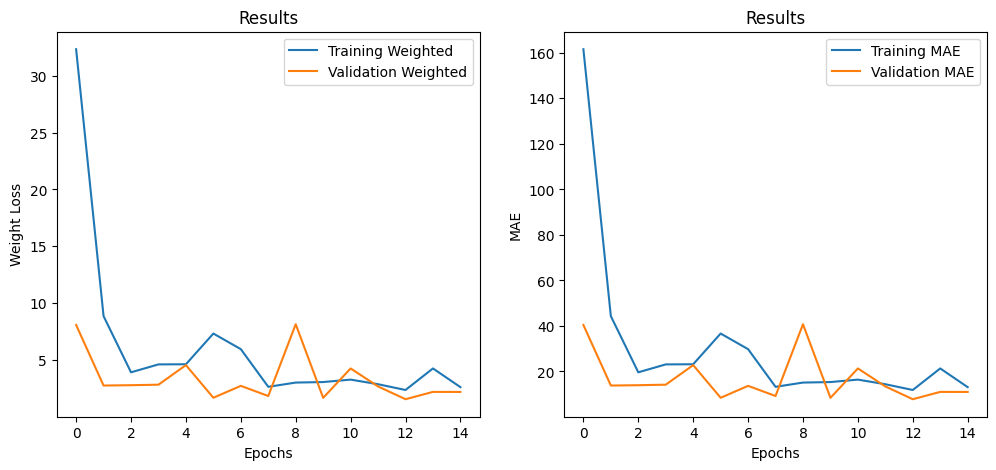

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Weighted')
plt.plot(val_losses, label='Validation Weighted')
plt.title('Results')
plt.ylabel('Weight Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mae_losses, label='Training MAE')
plt.plot(val_mae_losses, label='Validation MAE')
plt.title('Results')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()

plt.show()

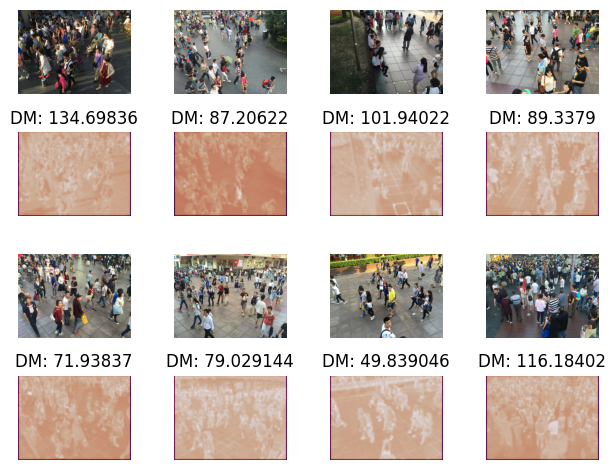

  114   152    33    50   117   137    32   575


In [20]:
best_model = MC_CNN().to(device)
best_model.load_state_dict(torch.load('./crowd_counting.pth'))
# Get some random validation images
dataiter = iter(val_loader)
ex_images, _, ex_gts  = next(dataiter)


# Show images and density map

pred_dms = best_model(ex_images.to(device))
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')

# Print labels
print(' '.join('%5s' % ex_gts[j].item() for j in range(batch_size)))

# Test Phase

In [21]:
best_model = MC_CNN().to(device)
best_model.load_state_dict(torch.load('./crowd_counting.pth'))
criterion = nn.L1Loss()

test_loss_acc = 0.0
with torch.inference_mode():
    for batch_img, batch_dmap, batch_gts in test_loader:
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)

        logits = best_model(batch_img)
        loss = criterion(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)

        # Keep running statistics
        test_loss_acc += loss.item()


# Print results
print('TEST:  test_MAE: {:.3f}'.format(test_loss_acc / len(test_loader.dataset)))


TEST:  test_MAE: 7.893


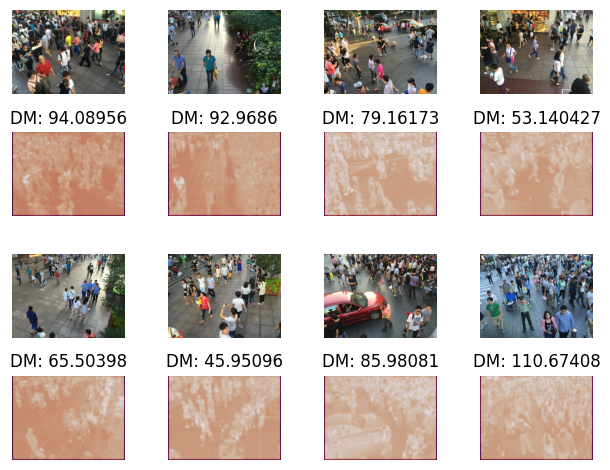

  117    29    89    45    73    47    90   170


In [22]:
# Get some random validation images
dataiter = iter(test_loader)
ex_images, _, ex_gts  = next(dataiter)


# Show images and density map

pred_dms = best_model(ex_images.to(device))
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')

# Print labels
print(' '.join('%5s' % ex_gts[j].item() for j in range(batch_size)))